In [4]:
import numpy as np
import pandas as pd
from chisq import EclipseFit
from etv_plots import nice_units, pretty_print, Plotter, ecl_time_to_etv, lsq_fit
from im_g1_fit import im, n1, g1
import emcee
import corner
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 24, 'lines.linewidth': 2})

In [5]:
system = '5095'

# Best Fit

In [6]:
chain : np.ndarray = np.load('mcmc_out/' + system + '_chains_1.npy')
prob = np.load('mcmc_out/' + system + '_probs_1.npy')
ndim = chain.shape[-1]
good_walkers = -2*prob[:, -1] < 300
print('Good walkers: {}/{}'.format(np.sum(good_walkers), chain.shape[0]))
best_indx = prob.flatten()[np.nonzero(prob.flatten())].argmax()
print('Best chi-squared:', -2*prob.flatten()[best_indx])
x = chain.reshape(-1, ndim)[best_indx].copy()
x[14] *= 2
print('\nBest Fit')
print(pretty_print(x))
y = np.median(chain.reshape(-1, ndim), axis=0)
print('\nMedian')
print(pretty_print(y))

Good walkers: 100/100
Best chi-squared: 78.22542511669839

Best Fit

             P (d)    Epoch (d)   i (deg)        e    ω (deg)    Ω (deg)
Binary    18.61085     66.86201    85.571    0.486      108.2        0.0
Planet      239.49       95.923     83.46   0.0551     -46.98      0.341

M_A (Msolar) 1.089
M_B (Msolar) 1.037
M_p (Mjup)   4.801
k2           0.0
    
γ (km/s)     4.515
γ (km/s)     77.5

Median

             P (d)    Epoch (d)   i (deg)        e    ω (deg)    Ω (deg)
Binary   18.610862     66.86211    85.838    0.494      108.6        0.0
Planet      239.51       95.654     86.09   0.0552     -46.82     0.0419

M_A (Msolar) 1.122
M_B (Msolar) 1.074
M_p (Mjup)   4.898
k2           0.0
    
γ (km/s)     4.65
γ (km/s)     77.47


In [7]:
fit = EclipseFit(system)
ecl_model, rv_model = fit.get_residuals(x, safe=False)
dbdt, b0 = fit.impact_regression(ecl_model)
print(b0, dbdt)

{'A': 1.2790166448220557} {'A': 4.036163186902379e-07}


# Data

In [8]:
plot = Plotter(system)

Text(0, 0.5, 'O-C (seconds)')

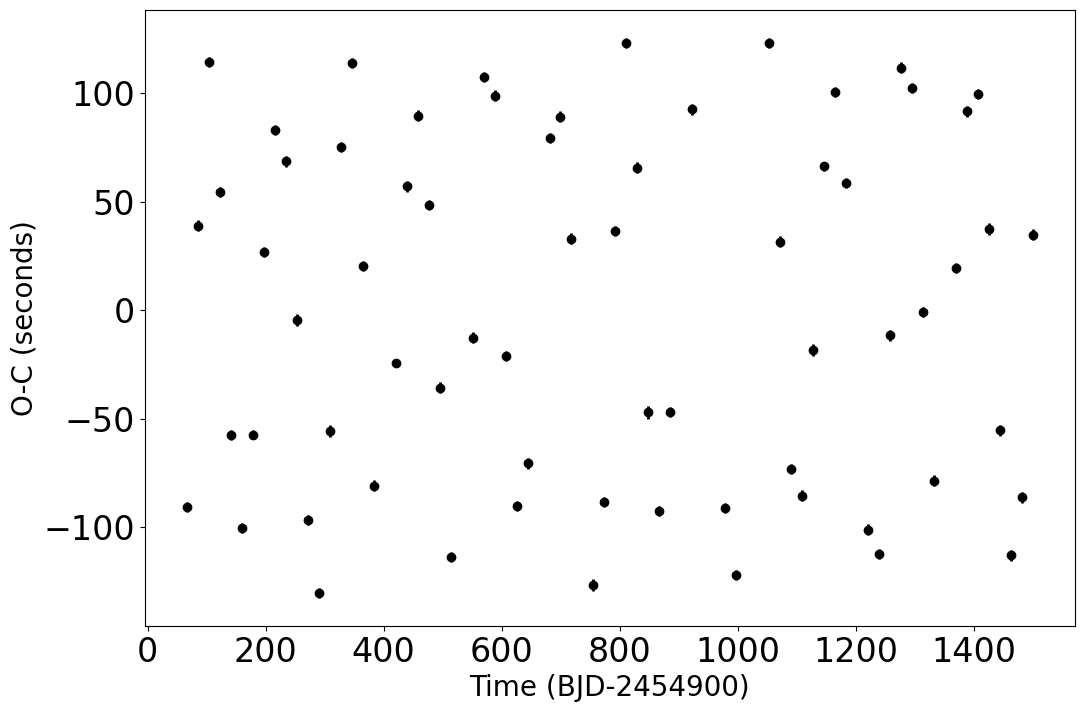

In [10]:
fig, ax = plt.subplots(figsize=(12,8))
T0, P = lsq_fit(ecl_model['A']['data_t'])
ax.errorbar(ecl_model['A']['data_t'], 86400*ecl_time_to_etv(ecl_model['A']['data_t'], P, T0), 
            86400*ecl_model['A']['data_err'], linestyle='None', color='k', marker='o')
ax.set_xlabel('Time (BJD-2454900)', fontsize=20)
ax.set_ylabel('O-C (seconds)', fontsize=20)
# plt.savefig(f'figures/etv_raw_unfolded_{system}.pdf', dpi='figure')

Text(0, 0.5, 'O-C (seconds)')

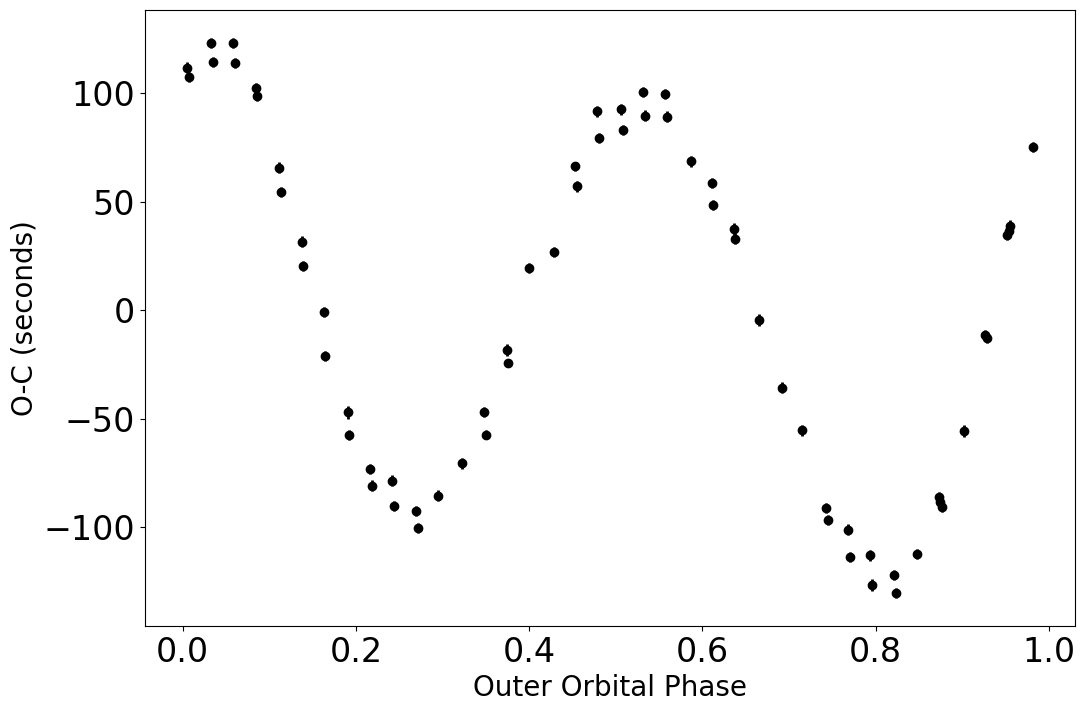

In [11]:
fig, ax = plt.subplots(figsize=(12,8))
T0, P = lsq_fit(ecl_model['A']['data_t'])
ax.errorbar(plot.time_to_phase(ecl_model['A']['data_t'], x[6], 235.9), 
            86400*ecl_time_to_etv(ecl_model['A']['data_t'], P, T0), 
            86400*ecl_model['A']['data_err'], linestyle='None', color='k', marker='o')
ax.set_xlabel('Outer Orbital Phase', fontsize=20)
ax.set_ylabel('O-C (seconds)', fontsize=20)
# plt.savefig(f'figures/etv_raw_folded_{system}.pdf', dpi='figure')

In [12]:
if len(plot.ecl_stars) == 2:
    plot.etv_together(x, ecl_max=3000)

# Model Fit

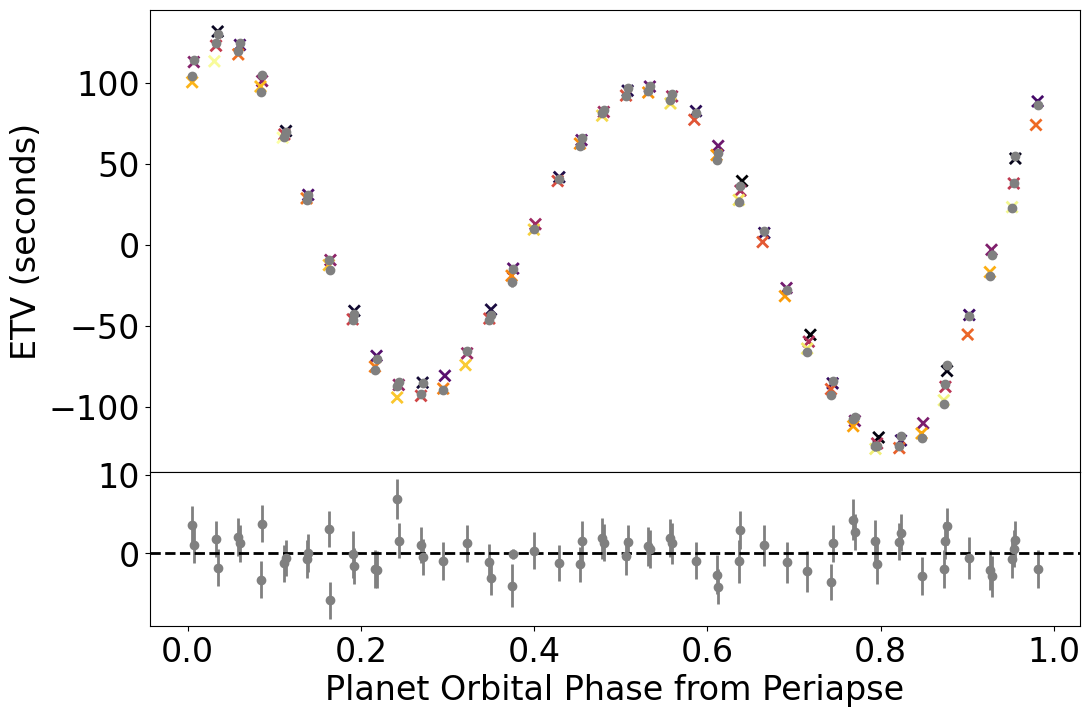

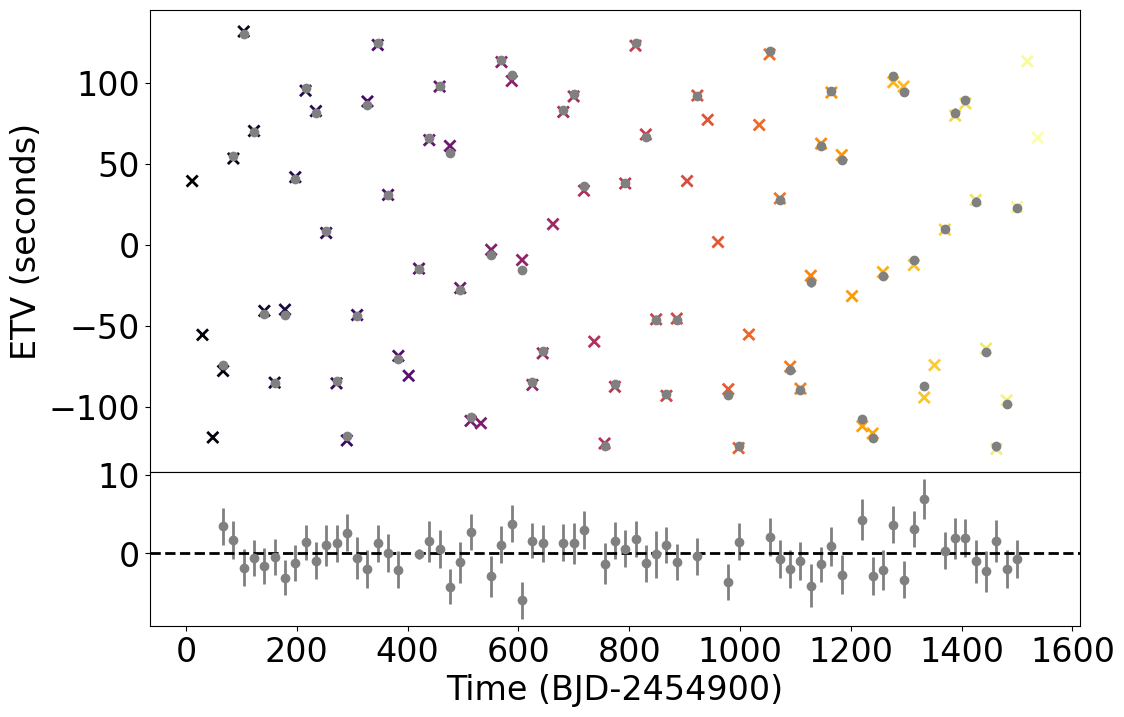

In [13]:
plot.etv_residuals(x, 'A', phased=True)
plt.savefig(f'figures/etv_residuals_phased_{system}.pdf', dpi='figure')
plot.etv_residuals(x, 'A', phased=False)
plt.savefig(f'figures/etv_residuals_unphased_{system}.pdf', dpi='figure')
try:
    plot.etv_residuals(x, 'B', phased=True)
    plot.etv_residuals(x, 'B', phased=False)
except:
    pass

Data:   3.991e-07 t + 1.295
Model:  4.036e-07 t + 1.279


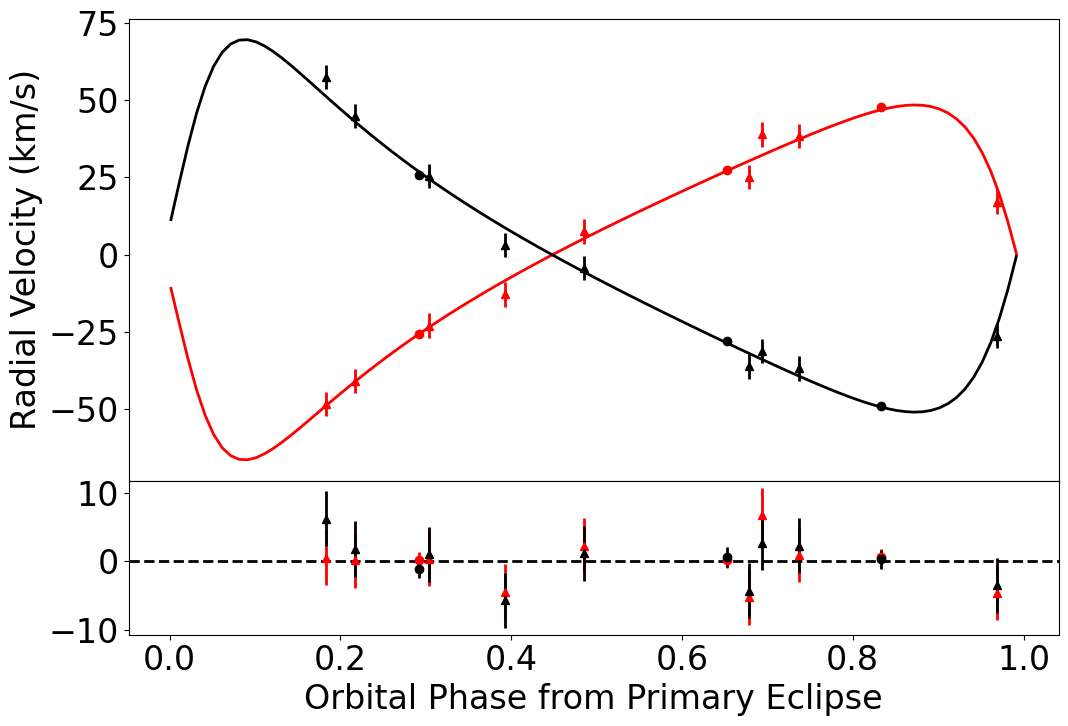

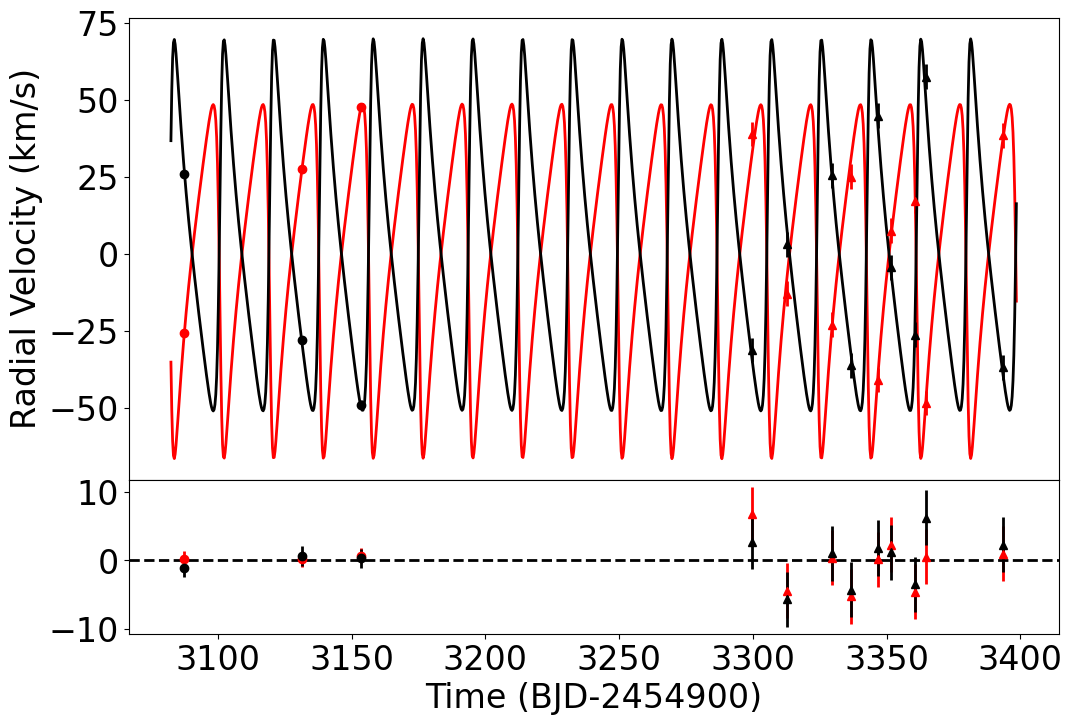

In [15]:
plot.rv_residuals(x, phased=True)
# plt.savefig(f'figures/rv_residuals_{system}.pdf', dpi='figure')
plot.rv_residuals(x, phased=False)
plot.impact_fit_quality(x)

# TESS Eclipses

/tmp/ipykernel_1415317/604886801.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  plot_tess.ecl_data['A'] = plot_tess.ecl_data['A'].append(tess_points)


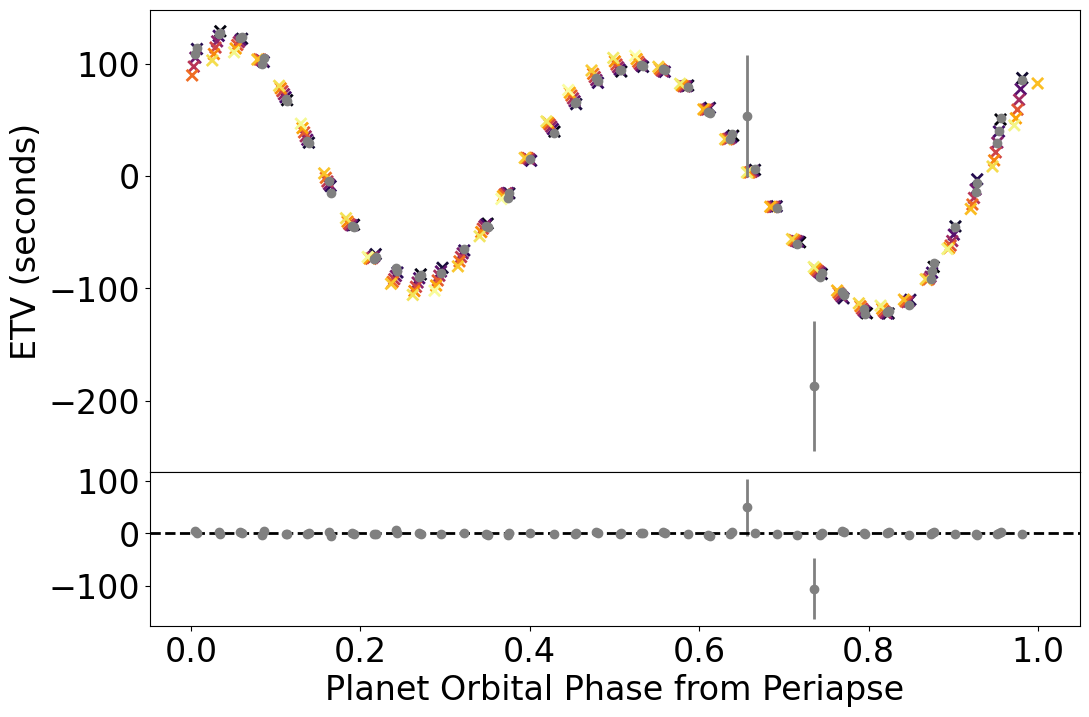

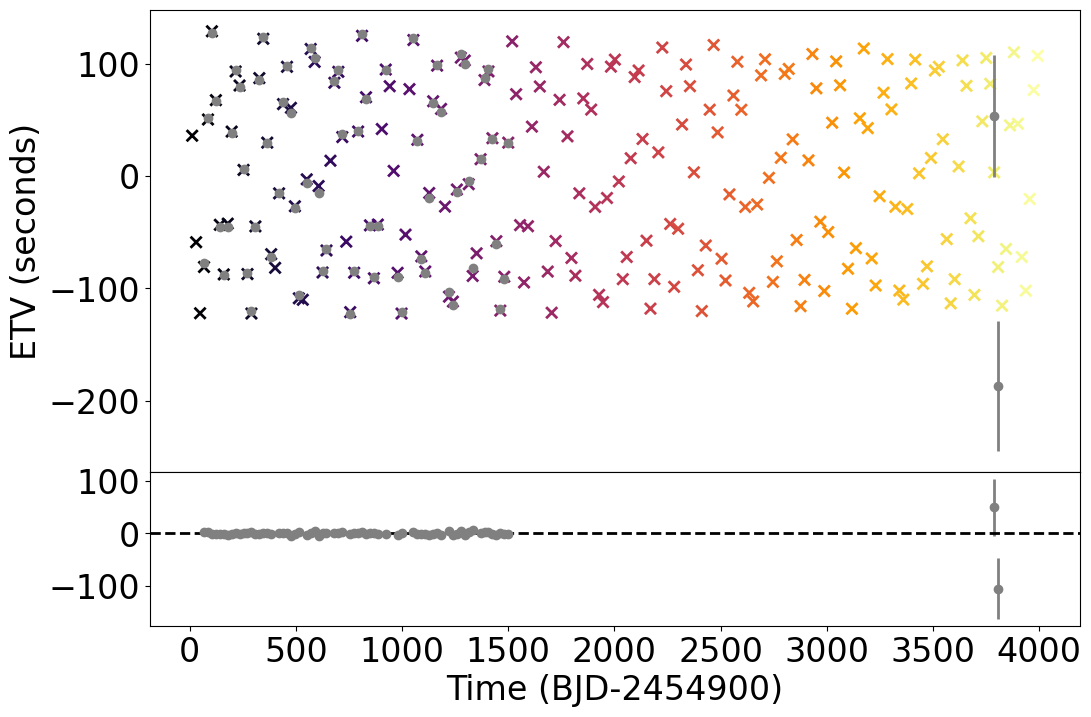

In [16]:
if system == '5095':
    plot_tess = Plotter(system)
    tess_points = pd.DataFrame([[3789.25839, 0.00063], [3807.86757, 0.00067]], index=[203, 204], columns=['data_t', 'data_err'])
    plot_tess.ecl_data['A'] = plot_tess.ecl_data['A'].append(tess_points)
    plot_tess.etv_residuals(x, 'A', phased=True, ecl_max=4000)
    plot_tess.etv_residuals(x, 'A', phased=False, ecl_max=4000)
    #plt.savefig('figures/etv_residuals_unfolded_tess.pdf', dpi='figure')

# MCMC Diagnostics

Text(0.5, 0, 'Generation')

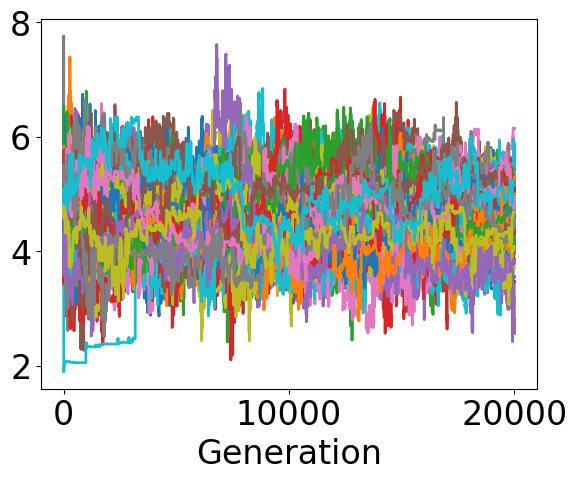

In [17]:
plt.plot(nice_units(chain)[...,15].T);
plt.xlabel('Generation')

Text(0, 0.5, '$\\chi^2$')

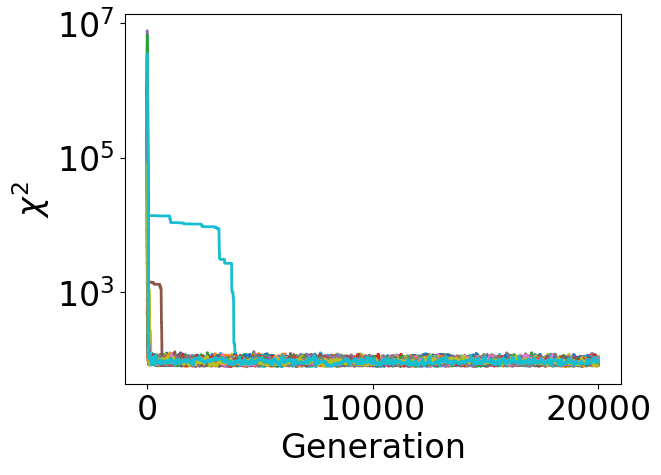

In [18]:
plt.plot(-2*prob.T)
plt.yscale('log')
plt.xlabel('Generation'); plt.ylabel('$\chi^2$')

In [19]:
print(-2*prob[:,-1])

[ 87.20129246  93.69011596  87.59825469  91.83310123  97.86626474
  89.74235033  85.39271803  93.77616791  98.94126805  94.27359259
  92.43475168 107.29181515  90.12158629  91.37936594  89.30082209
  89.33636794  90.93030405  97.73768771  97.09368246  90.11476666
  89.92853778  93.66964771 111.32009891  96.04627384  91.36403508
  89.4136063   88.30820694  97.8588313   88.41492411  91.2993493
  92.50292822  91.57905055 103.7510535   90.82723027  97.71074555
  85.21761885  99.02909133  87.1673228   81.96216338  85.625597
 108.18826542  84.50431579  86.19685865  99.32493629  93.53670572
  96.17247447  99.95206736 100.48508747  93.60553258  84.96999235
  88.16582155  91.08347937  86.7470715   99.24365996 100.39729788
  94.80657137 101.31771585  86.04552653  89.21393184  86.50697452
  88.64704951  89.0621717   92.74154655 102.24208342 104.06306685
  92.28044107  98.56068555  98.82957974 112.45590493  89.68158512
  92.51782227  87.6648365   92.68322491  98.58267561  97.72473175
  90.84961586

In [20]:
dof = sum(map(len, plot.ecl_data.values())) + sum(map(len, plot.rv_data.values()))
print('Reduced chi^2: {:.4f}'.format(-2*prob.flatten()[best_indx]/dof))

Reduced chi^2: 0.8596


In [21]:
emcee.autocorr.integrated_time(chain[3,:,1])

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [605.68632343]

In [ ]:
if system == '5095':
    labels = ['$P_1$', '$T_{01}$', '$i_1$', '$e_1$', '$\omega_1$',
              '$P_2$', '$T_{p2}$', '$e_2\cos\omega_2$', '$e_2\sin\omega_2$', '$i_2$', '$\Omega_2$',
              '$M_A$', '$M_B$', '$M_p$', '$\gamma_{NOT}$', '$\gamma_{CAHA}$']
corner.corner((nice_units(chain[:, 5000:, :].reshape(-1, 17)).T[chain.reshape(-1, 17).std(axis=0) > 1e-10]).T,
              labels=labels, plot_datapoints=False, max_n_ticks=0, labelpad=-0.1, label_kwargs={'fontsize':30})
              #levels=1 - np.exp(-0.5 * np.arange(1, 2.1, 1)**2))
# plt.savefig(f'figures/{system}_corner.pdf', dpi='figure')

# Derived system quantities

In [22]:
i_ms = {'Kepler-16b': [0.31, 'C1'], 
'Kepler-34b': [1.86, 'C2'], 'Kepler-35b': [1.07, 'C3'], 
'Kepler-38b': [0.18, 'C4'], 
'Kepler-47b': [0.27, 'C5'], 'Kepler-47c': [1.16, 'C5'], 'Kepler-47d': [1.38, 'C5'], 
'Kepler-64b': [2.81, 'C6'], 
'Kepler-413b': [4.07, 'C7'], 'Kepler-453b': [2.30, 'C8'], 'Kepler-1647b': [2.99, 'C9'], 
'Kepler-1661b': [0.93, 'C10'], 'PH-1b': [2.81, 'C11'], 'TOI-1338b': [0.98, 'C12']}

i_ms = pd.DataFrame(i_ms, index=['i_m', 'c']).T
i_ms['c'].values

array(['C1', 'C2', 'C3', 'C4', 'C5', 'C5', 'C5', 'C6', 'C7', 'C8', 'C9',
       'C10', 'C11', 'C12'], dtype=object)

95% upper limit of mutual inclination: 6.298 deg
Median mutual inclination: 2.728 deg
Best fit i_m: 2.135


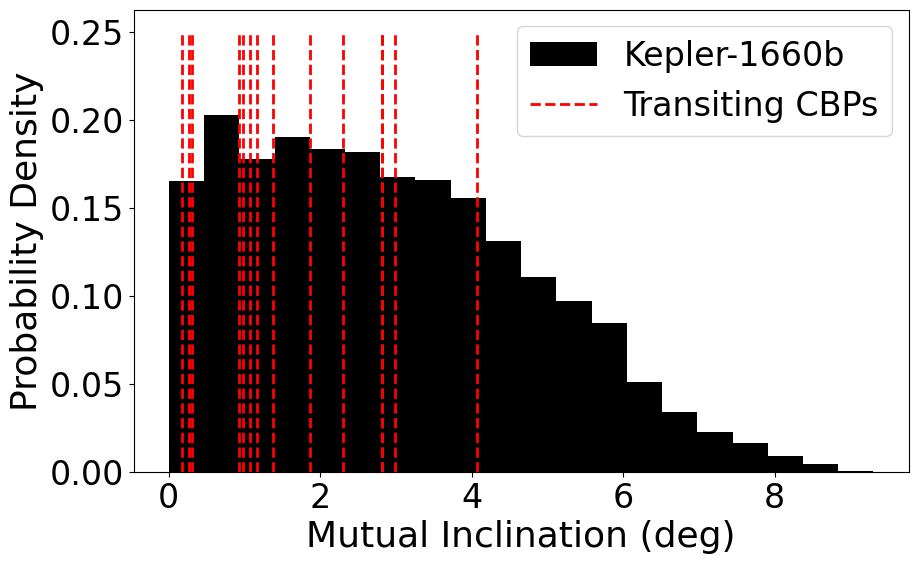

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.hist(np.degrees(im(chain[:,5000:,2], chain[:,5000:,9], chain[:,5000:,10])).flatten(), 
         bins=20, density=True, color='k', label='Kepler-1660b')
ax.set_xlabel('Mutual Inclination (deg)', fontsize=26)
ax.set_ylabel('Probability Density', fontsize=26)
ax.vlines(x=i_ms['i_m'], ymin=0, ymax=0.25, linestyles='dashed', linewidth=2, colors='red', label='Transiting CBPs')
plt.legend()
plt.savefig(f'figures/im_constraint_{system}.pdf', dpi='figure', bbox_inches="tight")

i_m_95_upper = np.percentile(np.degrees(im(chain[:,5000:,2], chain[:,5000:,9], chain[:,5000:,10])).flatten(), 95)
print('95% upper limit of mutual inclination: {:.3f} deg'.format(i_m_95_upper))
print('Median mutual inclination: {:.3f} deg'.format(np.median(np.degrees(im(chain[:,5000:,2], chain[:,5000:,9], chain[:,5000:,10])))))
i_m_chain = np.degrees(im(chain[:,5000:,2], chain[:,5000:,9], chain[:,5000:,10])).flatten()
# print(np.abs(np.percentile(i_m_chain, 84.15) - np.percentile(i_m_chain, 50)))
# print(np.abs(np.percentile(i_m_chain, 15.85) - np.percentile(i_m_chain, 50)))
print('Best fit i_m: {:.3f}'.format(np.degrees(im(x[2], x[9], x[10]))))

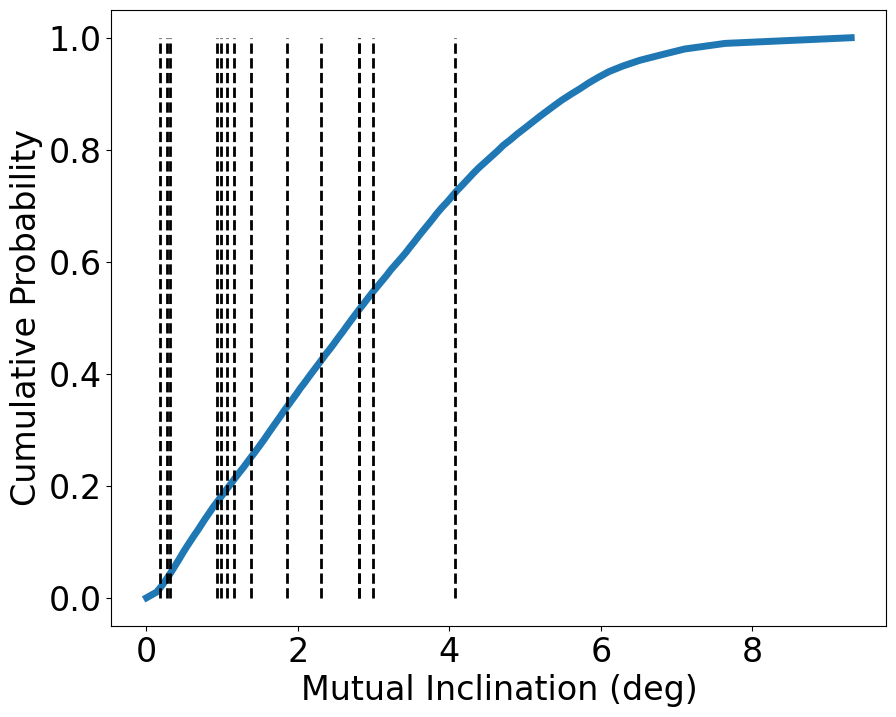

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(10,8))
ax.plot(np.quantile(np.degrees(im(chain[:,5000:,2], chain[:,5000:,9], chain[:,5000:,10])).flatten(), np.linspace(0, 1, 100)), np.linspace(0, 1, 100), lw=5)
ax.set_xlabel('Mutual Inclination (deg)', fontsize=24)
ax.set_ylabel('Cumulative Probability', fontsize=24)
ax.vlines(i_ms['i_m'], 0, 1, linestyles='dashed', linewidth=2, color='k')
# plt.savefig(f'figures/im_constraint_cdf_{system}.pdf', dpi='figure', bbox_inches="tight")

Text(0.5, 0, 'Dynamical Argument of Periastron')

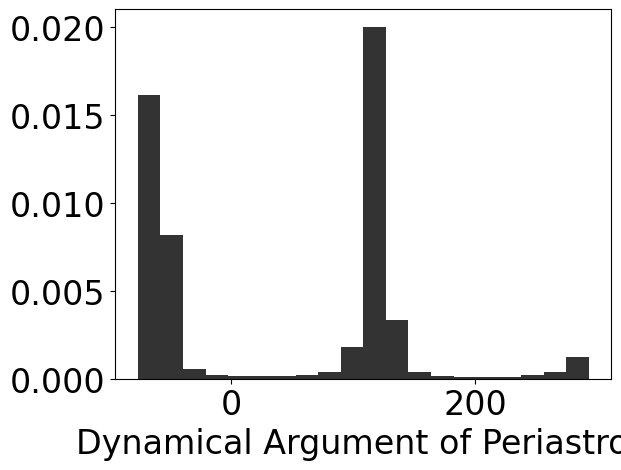

In [27]:
plt.hist(np.degrees(g1(chain[:,5000:,2], chain[:,5000:,9], chain[:,5000:,10], chain[:,5000:,4]).flatten()), 
         bins=20, density=True, color='0.2')
plt.xlabel('Dynamical Argument of Periastron')

a_planet/a_c = 1.521 ± 0.016


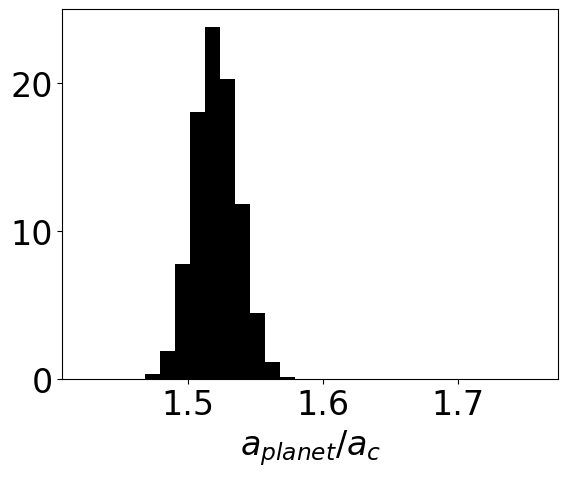

In [28]:
def stab_criterion(mu, e):
    return 1.6 + 5.1 * e - 2.22 * e**2 + 4.12 * mu - 4.27 * e * mu - 5.09 * mu**2 + 4.61 * e**2 * mu**2

def crit_radius(P1, P2, e, mA, mB):
    mu = mB/(mA + mB)
    return (P2/P1)**(2/3) / stab_criterion(mu, e)

a_c = crit_radius(chain[...,0], chain[...,5], chain[...,3], chain[...,11], chain[...,12])
plt.hist(a_c.flatten(), bins=30, color='k', density=True);
plt.xlabel(r'$a_{planet}/a_c$')
print('a_planet/a_c = {:.3f} ± {:.3f}'.format(a_c.mean(), a_c.std()))

T_prec = 86.076 ± 0.585


/tmp/ipykernel_1415317/3853879042.py:10: RuntimeWarning: invalid value encountered in arcsin
  return np.where(k_sq_ < 1, ellipk(k_sq_), ellipkinc(np.arcsin(1/np.sqrt(k_sq_)), k_sq_))


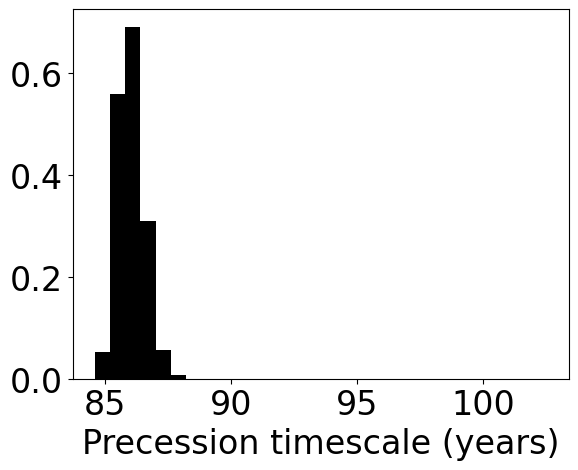

In [29]:
from scipy.special import ellipk, ellipkinc

def h(im, g1, e1):
    return np.cos(im)**2 - e1**2/2*np.sin(im)**2 * (3 - 5*np.cos(2*g1))

def k_sq(e1, h):
    return 5*e1**2/(1 - e1**2)*(1 - h)/(h + 4*e1**2)

def K(k_sq_):
    return np.where(k_sq_ < 1, ellipk(k_sq_), ellipkinc(np.arcsin(1/np.sqrt(k_sq_)), k_sq_))

# Farago & Laskar (2010) Eq. 2.32
def prec_timescale(P1, P2, e1, e2, im, g1, mA, mB):
    h_ = h(im, g1, e1)
    k_sq_ = k_sq(e1, h_)
    return 8/(3*np.pi) * (mA + mB)**2/(mA * mB) * (P2**7/P1**4)**(1/3) * K(k_sq_) * \
            (1 - e2**2)**2/np.sqrt((1 - e1**2) * (h_ + 4*e1**2))

T_precs = prec_timescale(chain[...,0], chain[...,5], chain[...,3], 
                         np.sqrt(chain[...,7]**2 + chain[...,8]**2), 
                         im(chain[...,2], chain[...,9], chain[...,10]), 
                         g1(chain[...,2], chain[...,9], chain[...,10], chain[...,4]), 
                         chain[...,11], chain[...,12])
plt.hist(T_precs[:,:5000].flatten()/365.25, bins=30, color='k', density=True)
plt.xlabel('Precession timescale (years)')
print('T_prec = {:.3f} ± {:.3f}'.format(T_precs.mean()/365.25, T_precs.std()/365.25))

In [30]:
# minimum mutual inclination to be guaranteed to transit

R_A = 1.45*0.00465
R_B = 1.34*0.00465
G = 0.00029591220828559104

delta = R_A + R_B

a_bin = (G*(chain[...,11] + chain[...,12])*chain[...,0]/(4*np.pi**2))**(1/3)
a_p = (G*(chain[...,11] + chain[...,12])*chain[...,5]/(4*np.pi**2))**(1/3)

mu_A = chain[...,11]/(chain[...,11] + chain[...,12])
mu_B = chain[...,12]/(chain[...,11] + chain[...,12])

i_m_lim_A = delta*(1/a_bin - mu_A*1/a_p) - R_A/a_p
i_m_lim_B = delta*(1/a_bin - mu_B*1/a_p) - R_B/a_p

print('Minimum i_m to transit A: {:.2f} deg'.format(np.degrees(i_m_lim_A.mean())))
print('Minimum i_m to transit B: {:.2f} deg'.format(np.degrees(i_m_lim_B.mean())))

# probability of transit

P_A = np.where(im(chain[...,2], chain[...,9], chain[...,10]) > i_m_lim_A, 1, (im(chain[...,2], chain[...,9], chain[...,10]) + R_A/a_p)/(delta*(1/a_bin - mu_B/a_p)))
P_B = np.where(im(chain[...,2], chain[...,9], chain[...,10]) > i_m_lim_B, 1, (im(chain[...,2], chain[...,9], chain[...,10]) + R_B/a_p)/(delta*(1/a_bin - mu_A/a_p)))

print('Probability of transiting A: {:.2f}%'.format(100*P_A.mean()))
print('Probability of transiting B: {:.2f}%'.format(100*P_B.mean()))

Minimum i_m to transit A: 6.18 deg
Minimum i_m to transit B: 6.47 deg
Probability of transiting A: 58.16%
Probability of transiting B: 56.75%


In [31]:
# Gaia
G = 2.959e-4
a_reflex = chain[...,13]/(chain[...,11] + chain[...,12])**(2/3) * (G/(4*np.pi**2) * chain[...,5]**2)**(1/3)
print('Reflex motion of binary: {:.5f} mas'.format(0.8216*a_reflex.mean()))

# Direct imaging
a_plan = (G*(chain[...,11] + chain[...,12])/(4*np.pi**2))**(1/3) * chain[...,5]**(2/3)
print('Separation of planet from binary: {:.4} mas'.format(0.8216*a_plan.mean()))

Reflex motion of binary: 0.00172 mas
Separation of planet from binary: 0.8057 mas


1.0453865865489842 0.02305032674145244


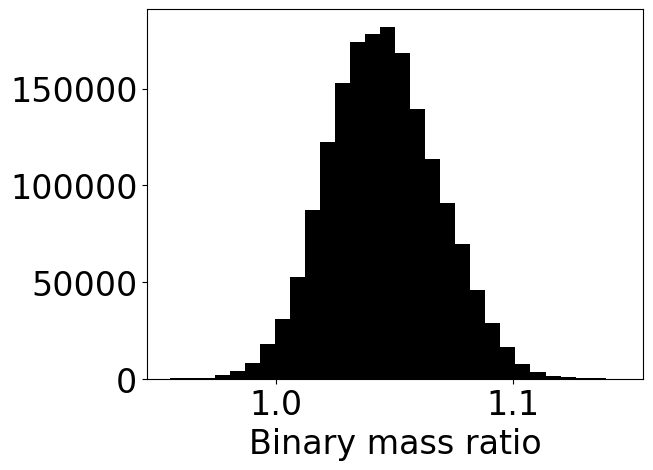

In [32]:
plt.hist((chain[:, 3000:,11]/chain[:,3000:,12]).flatten(), bins=30, color='k')
plt.xlabel('Binary mass ratio');
mass_rat = (chain[:, 3000:,11]/chain[:,3000:,12]).flatten()
print(mass_rat.mean(), mass_rat.std())

# Output for paper

In [33]:
burn_in = 5000
flatchain = chain[:,burn_in:,:].reshape(-1, ndim)
paper_chain = np.empty_like(flatchain)
paper_chain[...,:2] = flatchain[...,:2] # P_1 and T_01
paper_chain[...,2] = flatchain[...,3] # e_1
paper_chain[...,3] = np.degrees(flatchain[...,2]) # i_1
paper_chain[...,4] = np.degrees(flatchain[...,4]) # omega_1
paper_chain[...,5:7] = flatchain[...,5:7] # P_2 and T_p2
paper_chain[...,7] = np.sqrt(flatchain[...,7]**2 + flatchain[...,8]**2) # e_2
paper_chain[...,8] = np.degrees(flatchain[...,9]) # i_2
paper_chain[...,9] = np.degrees(np.arctan2(flatchain[...,8], flatchain[...,7])) # omega_2
paper_chain[...,10] = np.degrees(flatchain[...,10]) # Omega_2
paper_chain[...,11:13] = flatchain[...,11:13] # M_A and M_B
paper_chain[...,13] = 1047.58*flatchain[...,13] # M_p
paper_chain[...,14:] = flatchain[...,14:] # k_1, gamma(s)

best_indx_paper = prob[:,5000:].flatten().argmax()

In [34]:
table = pd.DataFrame(index=['Orbital Period, $P_1$ (days)', 'Time of eclipse, $T_{01}$ (BJD-2454900)', 'Eccentricity, $e_1$', 'Inclination, $i_1$ (degrees)', 
                            'Argument of periapse, $\omega_1$ (degrees)', 'Orbital period, $P_2$ (days)', 'Time of periapse, $T_P$ (BJD-2454900)', 
                            'Eccentricity, $e_2$', 'Inclination, $i_2$', 'Argument of periapse, $\omega_2$ (degrees)', 'Longitude of ascending node, $\Omega_2$ (degrees)', 
                            'Primary star mass, $M_A$ $(M_\odot)$', 'Secondary star mass, $M_B$ $(M_\odot)$', 'Planet mass, $M_p$ $(M_J)$', 
                            'k_2', 'Barycentric radial velocity (NOT), $\gamma_1$ (km/s)', 'Barycentric radial velocity (CARMENES), $\gamma_2$ (km/s)'])

table['Maximum Likelihood Value'] = paper_chain[best_indx_paper]
table['Median'] = np.median(paper_chain, axis=0)
# table['Upper uncertainty'] = np.abs(np.percentile(paper_chain, 84.15, axis=0) - np.percentile(paper_chain, 50, axis=0))
# table['Lower uncertainty'] = np.abs(np.percentile(paper_chain, 15.85, axis=0) - np.percentile(paper_chain, 50, axis=0))
table['1\sigma uncertainty'] = paper_chain.std(axis=0)
print(table.style.to_latex(column_format='cccc',
    environment='deluxetable'))

\begin{deluxetable}
\begin{tabular}{cccc}
 & Maximum Likelihood Value & Median & 1\sigma uncertainty \\
Orbital Period, $P_1$ (days) & 18.610850 & 18.610863 & 0.000033 \\
Time of eclipse, $T_{01}$ (BJD-2454900) & 66.862009 & 66.862079 & 0.000202 \\
Eccentricity, $e_1$ & 0.485545 & 0.494246 & 0.018107 \\
Inclination, $i_1$ (degrees) & 85.570653 & 85.695485 & 0.756868 \\
Argument of periapse, $\omega_1$ (degrees) & 108.195242 & 108.778735 & 1.876366 \\
Orbital period, $P_2$ (days) & 239.492268 & 239.509126 & 0.054586 \\
Time of periapse, $T_P$ (BJD-2454900) & 95.923135 & 95.649465 & 0.841233 \\
Eccentricity, $e_2$ & 0.055136 & 0.055281 & 0.001492 \\
Inclination, $i_2$ & 83.462837 & 85.778468 & 3.492665 \\
Argument of periapse, $\omega_2$ (degrees) & -46.975579 & -46.593917 & 1.978376 \\
Longitude of ascending node, $\Omega_2$ (degrees) & 0.341056 & 0.026207 & 0.689976 \\
Primary star mass, $M_A$ $(M_\odot)$ & 1.088662 & 1.126938 & 0.075613 \\
Secondary star mass, $M_B$ $(M_\odot)$ & 1.03

# Long term evolution

Text(0.5, 0, 'Time (days)')

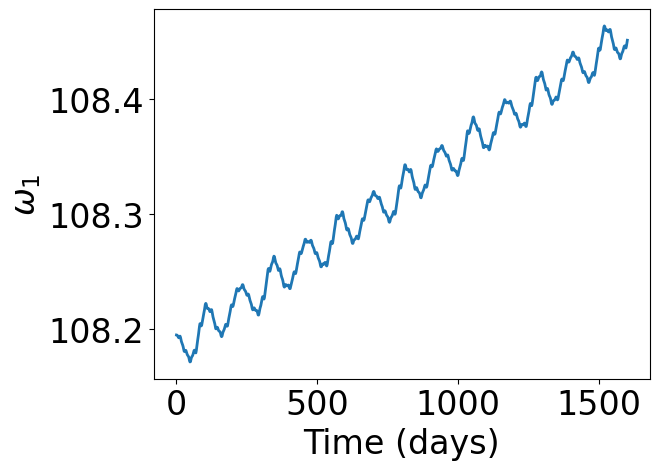

In [35]:
sim = plot.set_up_sim(x)
N = 1000
prec = np.zeros((N,6))
ts = np.linspace(0, 1600, N)
for i in range(N):
    sim.integrate(ts[i])
    prec[i,0] = ts[i]
    prec[i,1] = sim.particles[1].inc
    prec[i,2] = sim.particles[2].a
    prec[i,3] = sim.particles[2].e
    prec[i,4] = sim.particles[1].omega
#plt.plot(prec[...,0], np.degrees(prec[...,1]))
prec[...,5] = prec[...,2]*(1 - prec[...,3]**2)/(1 + prec[...,3]*np.sin(prec[...,4])) * np.cos(prec[...,1])/(1.2*0.00465)
plt.plot(prec[...,0], np.degrees(prec[...,4]))
plt.ylabel('$\omega_1$'); plt.xlabel('Time (days)')

In [36]:
sim = plot.set_up_sim(x)
N = 1000
prec = np.zeros((N,7))
ts = np.linspace(0, T_precs.max(), N)
for i in range(N):
    sim.integrate(ts[i])
    prec[i,0] = ts[i]
    prec[i,1] = sim.particles[1].inc
    prec[i,2] = sim.particles[2].inc
    prec[i,3] = sim.particles[2].Omega - sim.particles[1].Omega
    prec[i,4] = sim.particles[1].omega
    prec[i,5] = sim.particles[2].e
    prec[i,6] = sim.particles[2].omega

Text(0, 0.5, 'Angle (degrees)')

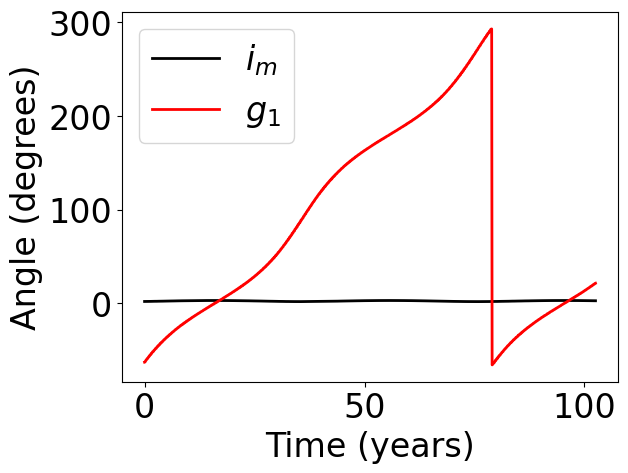

In [37]:
fig, ax1 = plt.subplots()
ax1.plot(prec[...,0]/365.25, np.degrees(im(*prec[...,1:4].T)), color='k', label='$i_m$')
ax1.plot(prec[...,0]/365.25, np.degrees(g1(*prec[...,1:5].T)), color='r', label='$g_1$')
ax1.legend()
ax1.set_xlabel('Time (years)'); ax1.set_ylabel('Angle (degrees)')

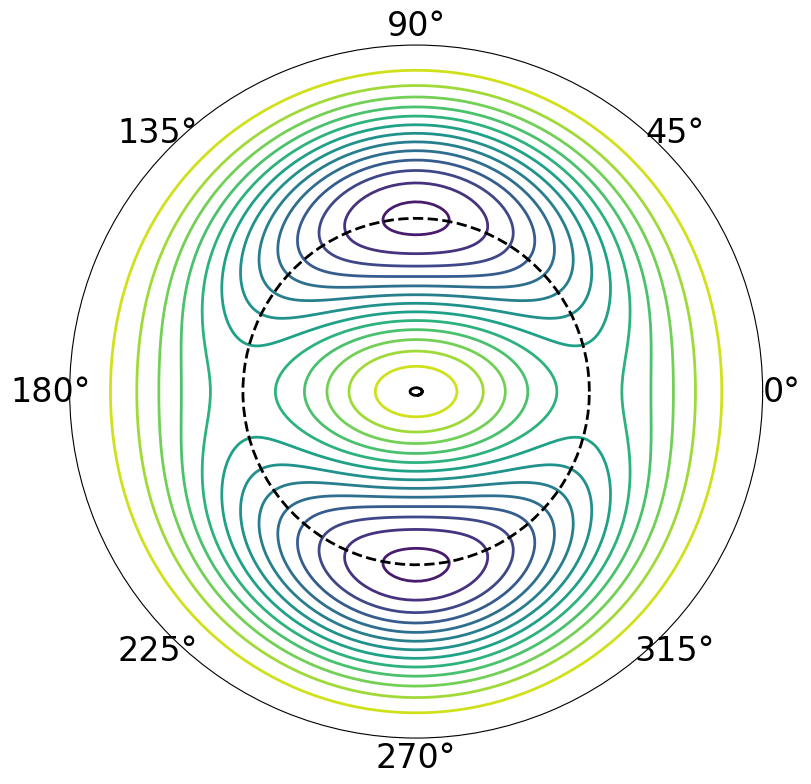

In [38]:
fig, ax = plt.subplots(subplot_kw=dict(projection='polar'), figsize=(16,9))
azimuths = np.radians(np.linspace(0, 360, 180))
zeniths = np.linspace(0,180,180)
r, theta = np.meshgrid(zeniths, azimuths)
values = h(np.radians(r), theta, x[3])
ax.contour(theta, r, values, 15)
ax.plot(np.linspace(0, 2*np.pi, 100), 90.0*np.ones(100), color='k', linestyle='--')
ax.set_yticklabels([])
ax.set_ylim(0, 180)
ax.grid(False)
mask = prob < 1000
#ax.scatter(g1(chain[...,2], chain[...,9], chain[...,10], chain[...,4])[mask].flatten(), 
#           np.degrees(im(chain[...,2], chain[...,9], chain[...,10]))[mask].flatten(), 
#           marker='.', color='k')
plt.plot(g1(*prec[...,1:5].T), np.degrees(im(*prec[...,1:4].T)), c='k')
#plt.plot(np.linspace(0, 2*np.pi, 100), np.array(100*[37.76]))
#plt.savefig('fl level curves.png', dpi='figure')

## Test out the Borkovits Analytic ETV model

/home/max/Documents/Fabrycky/etv-fit/etv.py:49: RuntimeWarning: invalid value encountered in double_scalars
  self.a_2 = (G * self.m_abc * (self.p_2/(2*np.pi))**2)**(1./3.)
/home/max/Documents/Fabrycky/etv-fit/etv.py:52: RuntimeWarning: invalid value encountered in double_scalars
  self.A_L1 = 15 * self.m_c * self.p_1 * (1 - self.e_2**2)**(-3./2.)/(8 * self.m_abc * self.p_2)
/home/max/Documents/Fabrycky/etv-fit/etv.py:54: RuntimeWarning: invalid value encountered in double_scalars
  self.A_S = self.p_1/self.p_2 * self.A_L1/(1-self.e_2**2)**(3./2.)


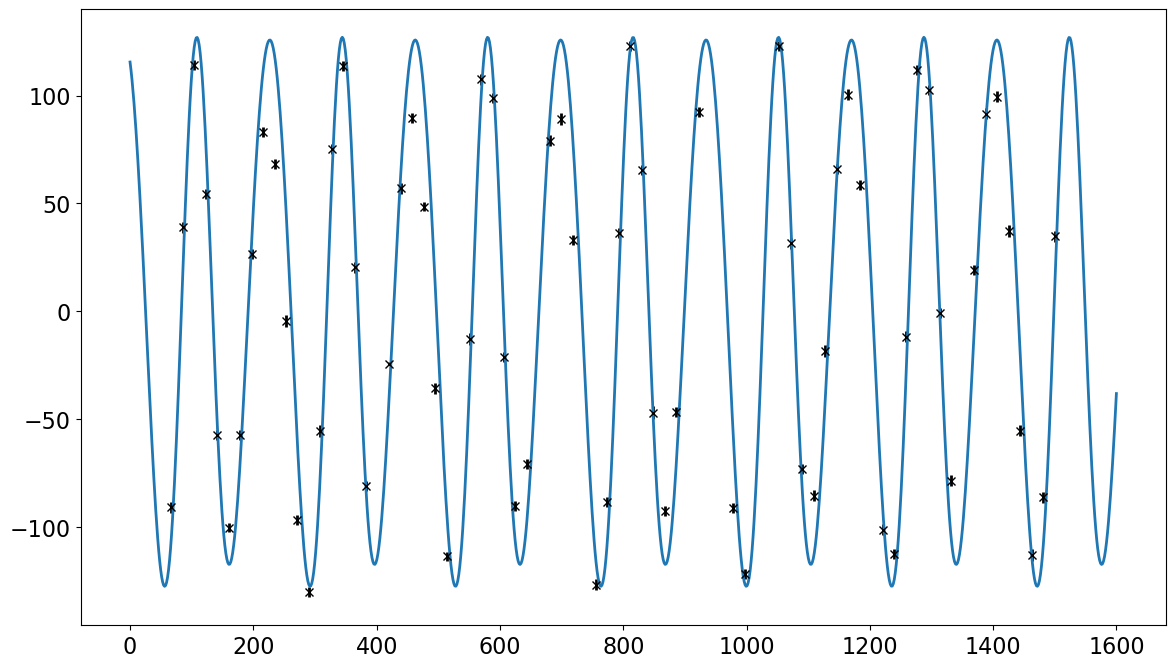

In [40]:
from analytic_etv import AnalyticETV
from scipy.stats import linregress

plt.figure(figsize=(14,8))
ts = np.linspace(0, 1600, 1000)
data = pd.read_csv('../data/KID5095269/koi509.tt.dan.db.try7.trans', 
                   header=None, delim_whitespace=True, index_col=0, names=['t', 'err'])
data.index = data.index.astype(int)
data.index = data.index + 41
p, t0, _, _, _ = linregress(data.index, data['t'])
data['etv'] = data['t'] - (p*data.index + t0)
plt.errorbar(data['t'], 86400*data['etv'], 86400*data['err'], linestyle='None', marker='x', c='k')

kic509 = AnalyticETV([18.61085, 66.86201, np.radians(81.35), 0.7057, np.radians(180+104.39),
                      235.8796, 95.923, 0.092*np.cos(np.radians(123)), 0.092*np.sin(np.radians(123)), np.radians(74.14), np.radians(99.4),
                      1.089, 1.037, 4.5/1047.5])
plt.plot(ts, 86400*kic509.del_tot_prim(ts))
